In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import json
import os
import dill
import numpy as np
import multiprocessing_on_dill as mp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import pickle

from collections import defaultdict, Counter
from tqdm import tqdm
from itertools import chain
from cityhash import CityHash64
from itertools import groupby

from f723.tools.urs.extraction import assemble_chains, get_sec_struct_model
from f723.tools.dataset.entities import NucleotideFeatures, PairFeatures, PairMeta, PairData, make_pair, Pair
from f723.tools.show.classification import plot_precision_recall_curve
from f723.tools.models.application import ClassificationResult

In [3]:
DATASET_DIR = '/home/mikhail/bioinformatics/data/dataset_all_60'

In [4]:
FEATURES_PATH = os.path.join(DATASET_DIR, 'features.npy')
TARGET_PATH = os.path.join(DATASET_DIR, 'target.npy')
GROUPS_PATH = os.path.join(DATASET_DIR, 'groups.npy')

In [5]:
FEATURES_SHAPE = (6830702, 465)

In [6]:
def load_features():
    features = np.memmap(FEATURES_PATH, shape=FEATURES_SHAPE)
    target = np.load(TARGET_PATH)
    pdb_ids = np.load(GROUPS_PATH)
    
    return features, target, pdb_ids

In [7]:
features, target, pdb_ids = load_features()

In [8]:
def get_batch(index):
    with open(os.path.join(DATASET_DIR, 'batch_{}'.format(index)), 'rb') as infile:
        return dill.load(infile)
    

def get_data():
    return chain.from_iterable((get_batch(i) for i in tqdm(range(30))))

In [9]:
chain_ids = ['{}.cif1_{}'.format(sample.meta.pdb_id, sample.meta.pair.nt_left.chain_id) 
             for sample in get_data()]

100%|██████████| 30/30 [01:24<00:00,  2.83s/it]


In [10]:
with open('/home/mikhail/bioinformatics/data/nonredundant.txt', 'r') as infile:
    nonredundant_chain_ids = infile.read().splitlines()

In [11]:
nonredundant_mask = np.repeat([chain_id in nonredundant_chain_ids for chain_id in chain_ids], 2)

In [12]:
nonredundant_mask.sum()

1494852

nonredundant / all = 1494852 / 6807514 -- всего в 4 раза меньше, не так ужи плохо 

In [13]:
mask = (target != 0) & nonredundant_mask 

features = features[mask]
target = target[mask]
pdb_ids = pdb_ids[mask]

In [14]:
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

In [15]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(features, target, pdb_ids)

feature_importances = []
target_pred = np.zeros_like(target)
pred_proba = np.zeros_like(target, dtype=np.float32)

for train_index, test_index in group_kfold.split(features, target, pdb_ids):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = target[train_index], target[test_index]
    print('Train positive rate: {}, test positive rate: {}'.format(
        np.mean(y_train == 1), np.mean(y_test == 1)))
    
    model = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=8)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    feature_importances.append(model.feature_importances_)
    target_pred[test_index] = y_pred
    pred_proba[test_index] = model.predict_proba(X_test)[:, 0]
    
    print(precision_recall_fscore_support(y_test, y_pred))

Train positive rate: 0.0028090995111181203, test positive rate: 0.002196188948895125
(array([0.84126984, 0.99788173]), array([0.03557047, 0.99998523]), array([0.06825499, 0.99893237]), array([  1490, 676958]))
Train positive rate: 0.0026193717645793075, test positive rate: 0.0023650688124221514
(array([0.7755102 , 0.99777971]), array([0.06138934, 0.99995787]), array([0.11377246, 0.9988676 ]), array([  1238, 522214]))
Train positive rate: 0.0024644285982737524, test positive rate: 0.003484320557491289
(array([1.        , 0.99669244]), array([0.0508982, 1.       ]), array([0.0968661 , 0.99834348]), array([  334, 95524]))
Train positive rate: 0.002454373188088759, test positive rate: 0.003630672926447574
(array([1.        , 0.99652528]), array([0.04310345, 1.        ]), array([0.08264463, 0.99825962]), array([  348, 95502]))
Train positive rate: 0.0024468860683922594, test positive rate: 0.0037310339109526574
(array([1.        , 0.99659949]), array([0.08888889, 1.        ]), array([0.1632

precision_recall_fscore_support


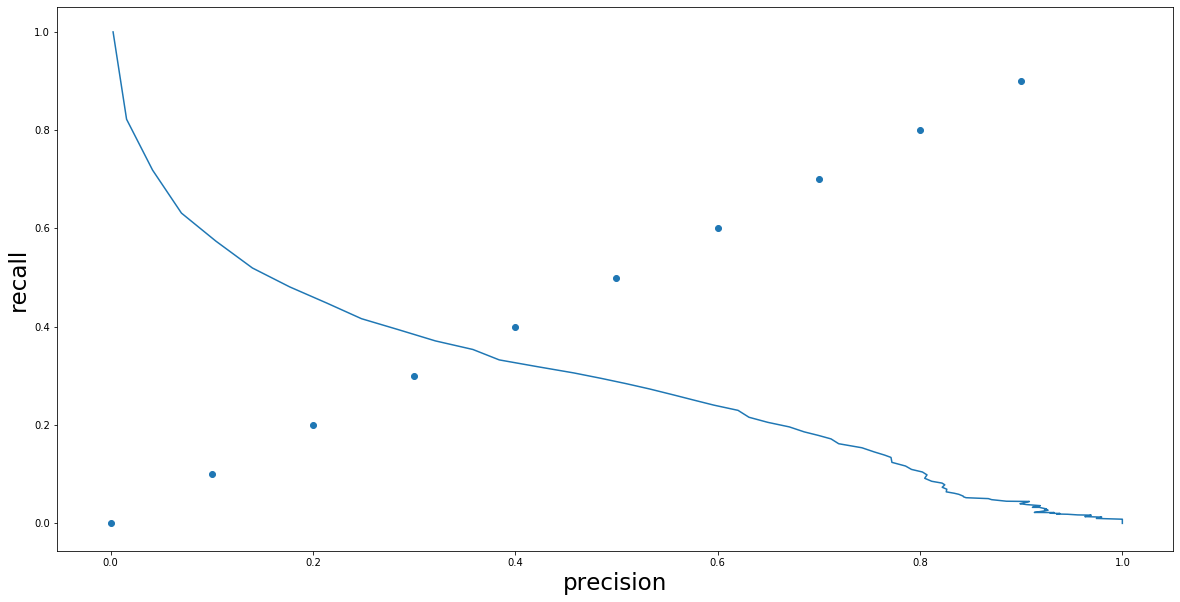

In [30]:
plt.figure(figsize=(20, 10))

plot_precision_recall_curve(ClassificationResult(
    target=target == 1, 
    predicted=target_pred == 1, 
    predicted_proba=pred_proba));

Выше random forest выбирает threshold так что recall очень мал при precision ~ 1. Подберем threshold так, чтобы precision и recall были сбалансированы, то есть по графику выше это precision ~ 0.4

In [32]:
precision, recall, thresholds = precision_recall_curve(target == 1, pred_proba)

In [33]:
index = np.argmin(np.abs(precision - 0.4))
threshold = thresholds[index]

precision[index], recall[index]

(0.38419117647058826, 0.33262599469496024)

In [34]:
shifted_target_pred = pred_proba > threshold

Попробуем отличить true_positive от false negative

In [35]:
true_positive_mask = (target == 1) & shifted_target_pred
false_negative_mask = (target == 1) & ~shifted_target_pred

In [36]:
np.sum(true_positive_mask), np.sum(false_negative_mask)

(1203, 2567)

In [37]:
new_features = np.array(list(features[true_positive_mask]) + list(features[false_negative_mask]), dtype=np.uint8)
new_target = np.zeros(true_positive_mask.sum() + false_negative_mask.sum(), dtype=np.uint8)
new_target[:true_positive_mask.sum()] = 1
new_target[-false_negative_mask.sum():] = 2

In [38]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True)
stratified_kfold.get_n_splits(new_features, new_target)

feature_importances = []

for train_index, test_index in stratified_kfold.split(new_features, new_target):
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = new_target[train_index], new_target[test_index]
    print('Train positive rate: {}, test positive rate: {}'.format(
        np.mean(y_train == 1), np.mean(y_test == 1)))
    
    model = RandomForestClassifier(n_estimators=100, n_jobs=8)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    feature_importances.append(model.feature_importances_)
    
    print(precision_recall_fscore_support(y_test, y_pred))

Train positive rate: 0.31907131011608625, test positive rate: 0.31920529801324504
(array([0.84186047, 0.88888889]), array([0.75103734, 0.93385214]), array([0.79385965, 0.91081594]), array([241, 514]))
Train positive rate: 0.31907131011608625, test positive rate: 0.31920529801324504
(array([0.86440678, 0.92870906]), array([0.84647303, 0.93774319]), array([0.85534591, 0.93320426]), array([241, 514]))
Train positive rate: 0.31896551724137934, test positive rate: 0.3196286472148541
(array([0.84684685, 0.90037594]), array([0.78008299, 0.9337232 ]), array([0.81209503, 0.91674641]), array([241, 513]))
Train positive rate: 0.3191912495856811, test positive rate: 0.3187250996015936
(array([0.84684685, 0.90207156]), array([0.78333333, 0.9337232 ]), array([0.81385281, 0.91762452]), array([240, 513]))
Train positive rate: 0.3191912495856811, test positive rate: 0.3187250996015936
(array([0.87793427, 0.90185185]), array([0.77916667, 0.94931774]), array([0.82560706, 0.92497626]), array([240, 513]))


Высокое качество, сравнимое с redundant датасетом.

In [40]:
lw_types = np.repeat(np.load(os.path.join(DATASET_DIR, 'lw.npy')), 2)[mask]

In [41]:
true_positive_counter = Counter(lw_types[true_positive_mask])
false_negative_counter = Counter(lw_types[false_negative_mask])
keys = list(true_positive_counter)

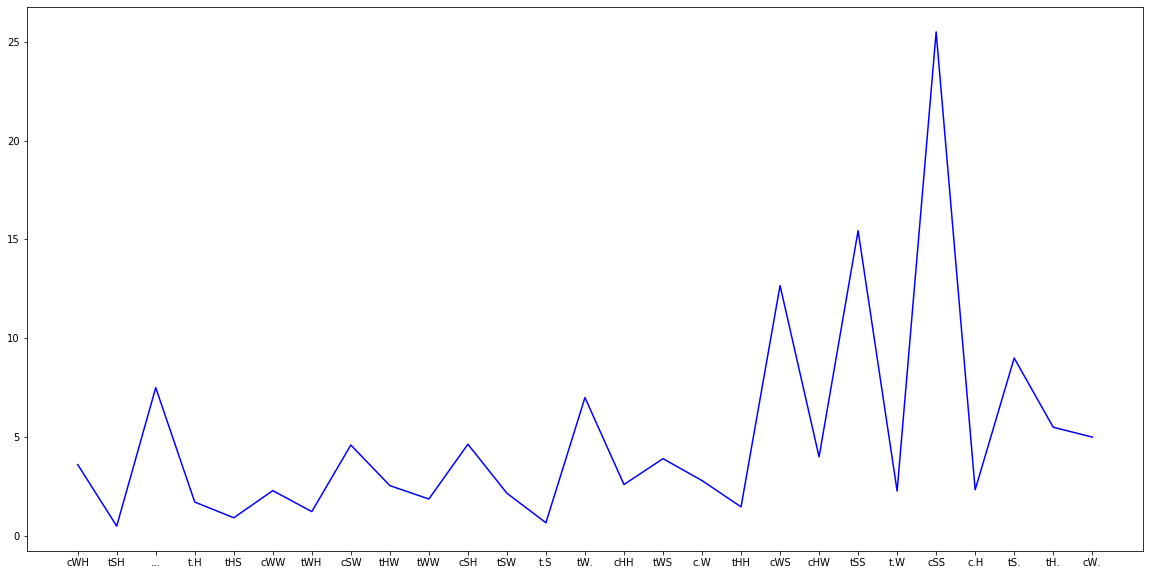

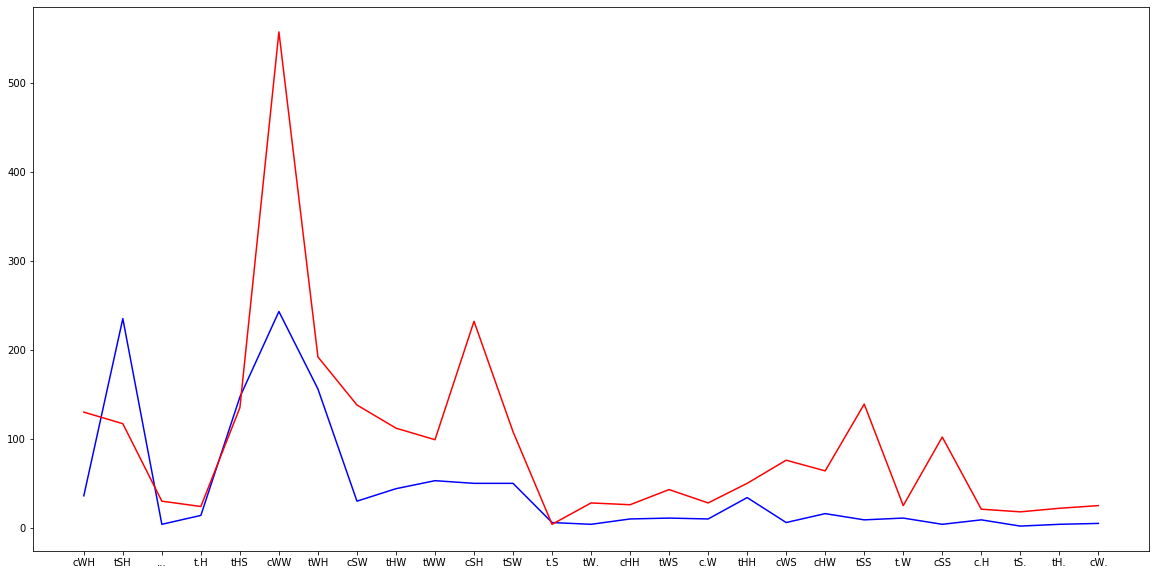

In [42]:
xs = np.arange(len(keys))
true_positive_num = np.array([true_positive_counter[k] for k in keys])
false_negative_num = np.array([false_negative_counter[k] for k in keys])

plt.figure(figsize=(20, 10))
plt.xticks(ticks=xs, labels=keys)
plt.plot(xs, false_negative_num / true_positive_num, c='b')

plt.figure(figsize=(20, 10))
plt.xticks(ticks=xs, labels=keys)
plt.plot(xs, true_positive_num, c='b')
plt.plot(xs, false_negative_num, c='r')

Выкинем true_positive пары, получим более "сложный" датасет и попытаемся поклассифицировать его.

In [43]:
selected_features = features[~true_positive_mask]
selected_target = target[~true_positive_mask]
selected_pdb_ids = pdb_ids[~true_positive_mask]

In [44]:
len(selected_target)

1488893

In [45]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(selected_features, selected_target, selected_pdb_ids)

for train_index, test_index in group_kfold.split(selected_features, selected_target, selected_pdb_ids):
    X_train, X_test = selected_features[train_index], selected_features[test_index]
    y_train, y_test = selected_target[train_index], selected_target[test_index]
    print('Train positive rate: {}, test positive rate: {}'.format(
        np.mean(y_train == 1), np.mean(y_test == 1)))
    
    model = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=8)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(precision_recall_fscore_support(y_test, y_pred))

Train positive rate: 0.001892951438088156, test positive rate: 0.001522146344341362
(array([0.        , 0.99847785]), array([0.        , 0.99999852]), array([0.        , 0.99923761]), array([  1032, 676958]))
Train positive rate: 0.0018955569842112837, test positive rate: 0.0014074003250788795


/home/mikhail/venv/f723/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.       , 0.9985926]), array([0., 1.]), array([0.       , 0.9992958]), array([   736, 522214]))
Train positive rate: 0.001656729638663533, test positive rate: 0.0027039159802478415


/home/mikhail/venv/f723/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.        , 0.99729608]), array([0., 1.]), array([0.        , 0.99864621]), array([  259, 95528]))
Train positive rate: 0.0016445160665128147, test positive rate: 0.002881663847647685


/home/mikhail/venv/f723/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.        , 0.99711834]), array([0., 1.]), array([0.        , 0.99855709]), array([  276, 95502]))
Train positive rate: 0.0016538540256587947, test positive rate: 0.0027389301572809895
(array([0.        , 0.99726107]), array([0., 1.]), array([0.        , 0.99862866]), array([  264, 96124]))


/home/mikhail/venv/f723/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Околонулевые precision/recall как и в случае с redundant датасетом